In [1]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import matrix_rank, inv
from pprint import pprint
import sys
import os
current_notebook_dir = os.getcwd()
# Replace with the path to your IT_PI.py function
project_root_dir = os.path.join(current_notebook_dir, '..', '..')
it_pi_module_dir = project_root_dir
sys.path.append(it_pi_module_dir)
import IT_PI
plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering/', VIEW.as_view(), name=''),

In [2]:
df = pd.read_csv('dataset_keyhole.csv')
df.describe()
output_list = ['e*']
input_list = ['etaP', 'Vs', 'rho', 'cp', 'Tl-T0', 'r0', 'alpha']
X = np.array(df[input_list])
Y = np.array(df[output_list])
num_input = 1
variables = input_list

In [3]:
D_in = np.matrix('2  1 1  2 -3  2  0; \
                 -3 -1 0 -1  0 -2  0; \
                  1  0 0  0  1  0  0; \
                  0  0 0  0  0 -1  1')
# Rearrange D_in columns accordingly: move 3rd and 4th columns (index 2 and 3) to the end
cols = list(range(D_in.shape[1]))
new_order = cols[:2] + cols[4:7] + [2, 3] + cols[7:]  # assumes 9 columns total
D_in = D_in[:, new_order]
print("Rank of D_in:", matrix_rank(D_in))
print("D_in matrix:\n", D_in)
num_rows          = np.shape(D_in)[0]
num_cols          = np.shape(D_in)[1]
# Function to calculate basis matrices

# Generate basis matrices
num_basis        = D_in.shape[1] -matrix_rank(D_in)
basis_matrices   = IT_PI.calc_basis(D_in, num_basis)
print("Basis vectors:")
pprint(basis_matrices)

Rank of D_in: 4
D_in matrix:
 [[ 2  1 -3  2  0  1  2]
 [-3 -1  0 -2  0  0 -1]
 [ 1  0  1  0  0  0  0]
 [ 0  0  0 -1  1  0  0]]
Basis vectors:
matrix([[-1.48029737e-16,  2.00000000e+00,  1.85037171e-17,
         -1.00000000e+00, -1.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 5.00000000e-01, -1.50000000e+00, -5.00000000e-01,
          0.00000000e+00,  0.00000000e+00, -1.00000000e+00,
          0.00000000e+00],
        [ 5.00000000e-01, -5.00000000e-01, -5.00000000e-01,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.00000000e+00]])


In [4]:
# Run dimensionless learning
results = IT_PI.main(
    X,
    Y.reshape(-1, 1),
    basis_matrices,
    num_input=num_input,
    estimator="kraskov",
    estimator_params={"k": 8},
    seed=42
)


input_PI = results["input_PI"]
output_PI = results["output_PI"]

epsilon  = results["irreducible_error"]
uq       = results["uncertainty"]

------------------------------------------------------------
num of parameters: 3

Using estimator: 'kraskov' with hyperparameters: {'k': 8}

(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 3 (seed=42, Sun Sep  7 12:22:39 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 -1.096323803390585e+00 1.0e+00 5.43e-01  4e-01  6e-01 0:00.1
    2    600 -1.244093751967635e+00 2.6e+00 7.24e-01  5e-01  7e-01 0:00.2
    3    900 -1.448114758409531e+00 8.3e+00 8.90e-01  4e-01  8e-01 0:00.3
   32   9600 -1.489412197549513e+00 5.8e+01 5.36e+00  5e-04  1e-03 0:03.4
   37  11100 -1.489412197549513e+00 6.3e+01 7.75e+00  9e-05  3e-04 0:03.8
termination on tolfunhist=1e-12
final/bestever f-value = -1.489412e+00 -1.489412e+00 after 11100/8367 evaluations
incumbent solution: [0.5913575, 0.84467762, 0.34553508]
std deviation: [2.15665518e-04, 3.19203798e-04, 8.71511744e-05]
Optimized_params: [0.59103192 0.84421656 0.3454125 ]
Optimized_MI: -1.4894121975495134
-----

In [5]:
#IT_PI.plot_scatter(input_PI,output_PI)
coef_pi_list     = results["input_coef"]
optimal_pi_lab   = IT_PI.create_labels(np.array(coef_pi_list).reshape(-1, len(variables)), variables)
for j, label in enumerate(optimal_pi_lab):
    print(f'Optimal_pi_lab[{j}] = {label}')

Optimal_pi_lab[0] = $\frac{etaP^{0.7}}{Vs^{0.3} \cdot rho^{0.7} \cdot cp^{0.7} \cdot Tl-T0^{0.7} \cdot r0^{1.0} \cdot alpha^{0.41}}$


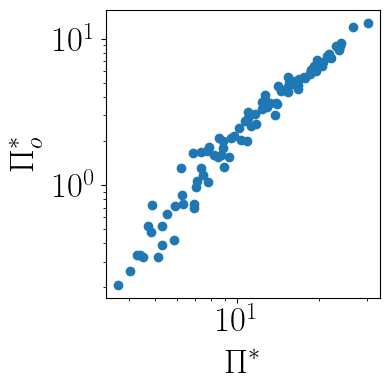

In [6]:
fig = plt.figure(figsize=(4, 4))
plt.scatter(input_PI,output_PI)
plt.xlabel(r" $\Pi^* $", fontsize=25, labelpad=8)  
plt.ylabel(r" $\Pi_{o}^*$", fontsize=25, labelpad=8)
plt.xscale("log")
plt.yscale("log")
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
fig.savefig("keyhole.pdf", format="pdf", bbox_inches="tight",transparent = "True")

In [7]:
print(f'Irreducible error (epsilon) = {epsilon}')
import pickle

workspace = {}
globals_copy = dict(globals())

for key, value in globals_copy.items():
    if not key.startswith('_') and not callable(value) and not hasattr(value, '__module__'):
        try:
            pickle.dumps(value)  # Test if it can be pickled
            workspace[key] = value
        except (TypeError, AttributeError):
            print(f"Skipping {key} - cannot pickle")

with open('output.pkl', 'wb') as f:
    pickle.dump(workspace, f)

Irreducible error (epsilon) = [0.23097639749348636]
Skipping np - cannot pickle
Skipping plt - cannot pickle
Skipping pd - cannot pickle
Skipping sys - cannot pickle
Skipping os - cannot pickle
Skipping IT_PI - cannot pickle
Skipping pickle - cannot pickle
